In [1]:
library(data.table)
library(limma)
library(dplyr)
library(edgeR)
library(tibble)
library(biomaRt)
library(tidyr)
library(stringr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Import gene names

In [3]:
ensembl = useEnsembl(biomart="ensembl", dataset="rnorvegicus_gene_ensembl", version=100)

In [4]:
gene_annot <- getBM(mart=ensembl, attributes=c('ensembl_gene_id', 'external_gene_name'))

In [5]:
base_dir <- "../"
species <- 'rn'
save_dir <- file.path(base_dir, 'DE_and_abundance')
meta_path <- file.path(base_dir, "meta_data", "meta_data.csv")
counts_path <- file.path(base_dir, "feature_counts", paste0("trimmed_gene_counts_", species, '.csv'))
annot_path <- file.path(base_dir, "feature_counts", paste0("trimmed_FC_gene_annot_", species, '.csv'))

In [6]:
FC_annot <- read.csv(annot_path, row.names=1)
## Select only gene id and length. Note that dplyr will drop row names upon select
## but edgeR expects gene id in row names, so convert gene_id to column, then back, 
## to row names after selecting
FC_annot <- rownames_to_column(FC_annot, var='gene_id')
FC_annot <- dplyr::select(FC_annot, 'gene_id', 'Length')
FC_annot <- column_to_rownames(FC_annot, var='gene_id')

In [7]:
meta <- read.csv(meta_path)

In [8]:
counts <- read.csv(counts_path, row.names=1)

In [9]:
## Change meta sample names to be acceptable variable names

In [10]:
meta$RatID <- factor(meta$RatID)

In [11]:
## Take counts in the filtered sample list 

In [12]:
counts <- dplyr::select(counts, meta$Sample)

In [13]:
## Get differential gene expression list for use in limma

In [14]:
y <- DGEList(counts, genes=FC_annot)

In [15]:
## Define the linear model and get the design matrix

In [16]:
design <- model.matrix(~ 0 + Condition, data=meta)

In [17]:
## Filter the data to remove low expressed genes

In [18]:
keep <- filterByExpr(y, design, min.count=10, min.total.count=15)
y <- y[keep, keep.lib.sizes=FALSE]

In [19]:
## Calculate library normalization factors 

In [20]:
y <- calcNormFactors(y)

In [21]:
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
sample_4821_in,1,1485191,1.0218358
sample_4822_in,1,1051776,1.0369153
sample_4823_in,1,1625907,1.0288750
sample_4831_in,1,2035788,1.0267511
sample_4832_in,1,1094028,0.9782528
sample_4833_in,1,937998,0.9325996
sample_4834_in,1,1288408,0.9080201
sample_4821_out,1,2290222,1.0127684
sample_4822_out,1,1900786,1.0234092


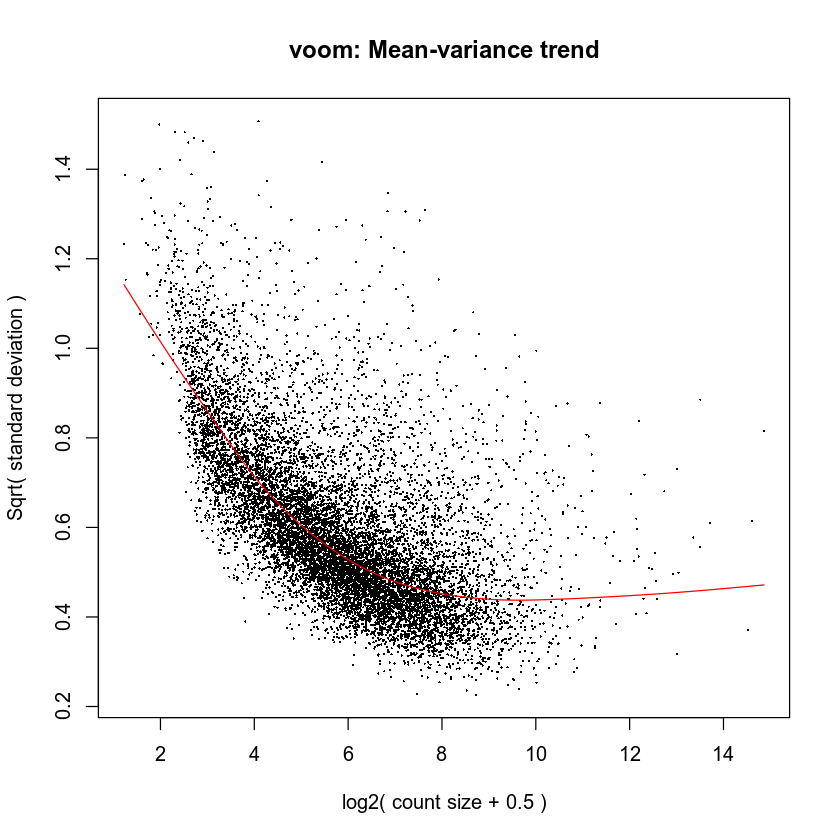

In [22]:
v <- voom(y,design, plot=TRUE)

In [23]:
## Fit the linear model and perform empirical Bayes smoothing

In [24]:
fit <- lmFit(v,design)
fit <- eBayes(fit)

In [25]:
# Get contrasts as all pairs of conditions
conditions <- colnames(design)
contr <- c()
#print(conditions)
for (i in 1:(length(conditions)-1)){
    for (j in (i+1):length(conditions)){
     contrast <- paste0(conditions[i], '-', conditions[j])
        contr <- c(contr, contrast)
    }
}

contrast.matrix <- makeContrasts(contrasts=contr, levels=design)
contrast.matrix

,ConditionAngptl7_KD3_in-ConditionAngptl7_KD3_out,ConditionAngptl7_KD3_in-ConditionNT4_in,ConditionAngptl7_KD3_in-ConditionNT4_out,ConditionAngptl7_KD3_out-ConditionNT4_in,ConditionAngptl7_KD3_out-ConditionNT4_out,ConditionNT4_in-ConditionNT4_out
ConditionAngptl7_KD3_in,1,1,1,0,0,0
ConditionAngptl7_KD3_out,-1,0,0,1,1,0
ConditionNT4_in,0,-1,0,-1,0,1
ConditionNT4_out,0,0,-1,0,-1,-1


In [26]:
## Fit coefficients for contrasts

In [27]:
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

In [28]:
############################################################
# Prepare DE top tables
############################################################

In [29]:
## Get abundance table with more readable samples names for combining with top table

In [30]:
head(v$E)

,sample_4821_in,sample_4822_in,sample_4823_in,sample_4831_in,sample_4832_in,sample_4833_in,sample_4834_in,sample_4821_out,sample_4822_out,sample_4823_out,sample_4831_out,sample_4832_out,sample_4833_out,sample_4834_out
ENSRNOG00000061316,6.469650,6.467330,6.296606,6.332930,6.353281,5.961196,6.191466,6.544431,6.436625,6.325253,6.567616,6.381619,6.101472,6.336565
ENSRNOG00000014303,3.442581,3.267191,3.115668,3.664246,3.149997,1.514940,3.021541,3.894732,3.712445,4.328052,3.528564,4.355285,4.344557,4.148025
ENSRNOG00000014330,4.464276,4.757516,4.796845,4.506181,5.010594,4.237406,4.446038,4.631698,4.781487,4.476696,4.885257,4.324588,4.670133,4.622705
ENSRNOG00000049505,4.126108,4.232425,4.090577,3.551035,3.760051,3.947899,1.943538,3.716945,4.189767,2.931534,3.597276,3.277283,3.326178,3.609159
ENSRNOG00000014916,7.149731,7.262890,7.254866,7.026438,7.046728,6.914111,6.721980,7.123829,7.386534,7.151296,7.435454,7.196940,7.333098,7.107650
ENSRNOG00000014996,3.683589,4.004156,3.211883,3.490914,3.856266,3.836868,3.983066,3.340796,3.767940,3.824619,3.597276,4.160469,4.344557,3.858518


In [31]:
voom_counts <- as.data.frame(v$E)
abundance <- 2.**(copy(voom_counts))
abundance <- setnames(abundance, old=meta$Sample, new=meta$Label)
abundance <- rownames_to_column(abundance, var='ensembl_gene_id')

In [32]:
## Get RPKM and convert to TPM

In [33]:
RPKM <- copy(rpkm(y))
TPM <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM <- setnames(as.data.frame(TPM), old=meta$Sample, new=meta$Label)
TPM <- rownames_to_column(TPM, var='ensembl_gene_id')

In [34]:
## Get top table with logFC and FDR

In [35]:
## Generate empty list to store top tables in 
tt_list <- list()
i <- 1
for (contrast in contr){
    top_table <- topTable(fit2, coef=contrast, number=Inf, sort.by="t")
    top_table <- rownames_to_column(top_table, var='ensembl_gene_id')
    top_table <- left_join(top_table, gene_annot, by='ensembl_gene_id')
    top_table <- dplyr::select(top_table, ensembl_gene_id, external_gene_name, everything())
    tt_list[[i]] <- top_table
    top_table_with_abundance <- left_join(top_table, abundance, by='ensembl_gene_id')
    top_table_with_TPM <- left_join(top_table, TPM, by='ensembl_gene_id')
    contrast_label <- str_remove_all(contrast, 'Condition')
    
    # Save top table (no abundance)
    filename <- paste0('toptable_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables', filename)
    write.csv(top_table, savepath, row.names=FALSE)
    
    # Save top table with CPM abundance
    filename <- paste0('toptable_and_CPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_CPM_abundance', filename)
    write.csv(top_table_with_abundance, savepath, row.names=FALSE)
    
    # Save top table with CPM abundance
    filename <- paste0('toptable_and_TPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_TPM_abundance', filename)
    write.csv(top_table_with_TPM, savepath, row.names=FALSE)
   
    i <- i + 1
}

In [36]:
################################################
# Prepare a table that combines all DE results
################################################

In [37]:
# replace contrasts with more readable labels

In [38]:
contr_label = str_remove_all(contr, 'Condition')
contr_label = paste0('_', contr_label)

In [39]:
# Join the tables

In [40]:
top_table_all <- tt_list[[1]]
for (i in 1:(length(contr_label)-1)){
    if (i < length(contr_label) -1){ 
        top_table_all <- left_join(top_table_all, tt_list[[i+1]], 
                           by=c('ensembl_gene_id', 'external_gene_name', 'Length'), 
                           suffix = c(contr_label[i], ''))
        } else{
            top_table_all <- left_join(top_table_all, tt_list[[i+1]], 
                               by=c('ensembl_gene_id', 'external_gene_name', 'Length'), 
                               suffix = c(contr_label[i], contr_label[i+1]))
        } 
            
    
}
top_table_all_CPM <- left_join(top_table_all, abundance, by='ensembl_gene_id')
top_table_all_TPM <- left_join(top_table_all, TPM, by='ensembl_gene_id')


In [41]:
# Save the top tables

In [42]:
filename <- paste0('top_table_all_comparisons_',species, '.csv')
savepath <- file.path(save_dir, 'top_tables', filename)
write.csv(top_table_all, savepath, row.names=FALSE)

In [43]:
filename <- paste0('top_table_all_comparisons_', species, 'CPM.csv')
savepath <- file.path(save_dir, 'top_tables_with_CPM_abundance', filename)
write.csv(top_table_all_CPM, savepath, row.names=FALSE)

In [44]:
filename <- paste0('top_table_all_comparisons_', species,'TPM.csv')
savepath <- file.path(save_dir, 'top_tables_with_TPM_abundance', filename)
write.csv(top_table_all_TPM, savepath, row.names=FALSE)

In [45]:
##################################
## Create tidy TPM and counts
#################################

In [46]:
## Cast the TPM table into tidy format and add sample info

In [47]:
RPKM <- copy(rpkm(y))
TPM2 <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM2 <- rownames_to_column(as.data.frame(TPM2), var='ensembl_gene_id')

In [48]:
TPM.tidy <- pivot_longer(TPM2, -ensembl_gene_id, names_to='Sample', values_to='TPM')
TPM.tidy <- left_join(TPM.tidy, meta, by='Sample')
TPM.tidy <- left_join(TPM.tidy, gene_annot, by='ensembl_gene_id')
TPM.tidy <- dplyr::select(TPM.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [49]:
filename <- paste0('TPM_', species, '.csv')
savefile <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM.tidy, savefile)

In [50]:
## Get the voom normalized counts per million

In [51]:
voom_cpm <- v$E
voom_cpm2 <- 2**voom_cpm
voom_cpm3 <- rownames_to_column(as.data.frame(voom_cpm2), var='ensembl_gene_id')
voom_cpm_tidy <- pivot_longer(voom_cpm3, -ensembl_gene_id, names_to='Sample', values_to='CPM')
voom_cpm_tidy <- left_join(voom_cpm_tidy, meta, by='Sample')
voom_cpm_tidy <- left_join(voom_cpm_tidy, gene_annot, by='ensembl_gene_id')
voom_cpm_tidy <- dplyr::select(voom_cpm_tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())
filename <- paste0('cpm_voom_tidy_',species, '.csv')
voom_cpm_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(voom_cpm_tidy, voom_cpm_save_file, row.names=FALSE)

In [52]:
## Get tidy raw counts`

In [53]:
counts2 <- rownames_to_column(counts, var='ensembl_gene_id')
genes <- gene_annot['ensembl_gene_id']
counts2 <- dplyr::filter(counts2, ensembl_gene_id %in% gene_annot$ensembl_gene_id)
counts.tidy <- pivot_longer(counts2, -ensembl_gene_id, names_to='Sample', values_to='Counts')
counts.tidy <- left_join(counts.tidy, meta, by='Sample')
counts.tidy <- left_join(counts.tidy, gene_annot, by='ensembl_gene_id')
counts.tidy <- dplyr::select(counts.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [54]:
filename <- paste0('Unfiltered_counts_tidy_', species, '.csv')
counts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(counts.tidy, counts_save_file, row.names=FALSE)

In [55]:
## Merge 

In [56]:
TPM_counts_tidy <- left_join(TPM.tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [57]:
TPM_cpm_tidy <- left_join(TPM.tidy, voom_cpm_tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [58]:
TPM_counts_cpm <- left_join(TPM_cpm_tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))
TPM_counts_cpm <- dplyr::select(TPM_counts_cpm, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [59]:
filename <- paste0('TPM_CPM_counts_', species, '.csv')
tpm_cpm_cts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM_counts_cpm, tpm_cpm_cts_save_file, row.names=FALSE)